In [ ]:
from pathlib import Path

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.earth_params import seconds_per_year

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

# ===================================
# 1. Define fair object
# ===================================

f = FAIR(ch4_method='thornhill2021')

# ===================================
# 2. Define the model
# ===================================

f.define_time(1750, 2100, 1)

# Define SSP scenarios
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios)


fl = Path("../data/calibration/output/fair-2.1.3/v1.4/all-2022/calibrations/4xCO2_cummins_ebm3_cmip6.csv")
df = pd.read_csv(fl)
models = df['model'].unique()
configs = []

for imodel, model in enumerate(models):
    for run in df.loc[df['model']==model, 'run']:
        configs.append(f"{model}_{run}")
        
f.define_configs(configs)

species, properties = read_properties()
f.define_species(species, properties)

# ===================================
# 3. Create input output data
# ===================================

f.allocate()

# ===================================
#  4. Fill in the data
# ===================================

#f.species_configs["baseline_emissions"].sel(specie="CH4", config="MPI-ESM1-2-HR_r1i1p1f1")

# ===================================
## 4.1 default species configs
# ===================================

f.fill_species_configs()

fill(f.species_configs['unperturbed_lifetime'], 10.8537568, specie='CH4')
fill(f.species_configs['baseline_emissions'], 19.01978312, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

# ===================================
## 4.2 fill emissions
# ===================================

fl = Path("../data/calibration/data/forcing/volcanic_ERF_monthly_-950001-201912.csv")
df_volcanic = pd.read_csv(fl, index_col='year')

# This function automatically selects the emissions, concentration or forcing 
# you want depending on the properties for each of the SSP scenarios defined.
f.fill_from_rcmip()

# overwrite volcanic
volcanic_forcing = np.zeros(351)
volcanic_forcing[:271] = df_volcanic[1749:].groupby(np.ceil(df_volcanic[1749:].index) // 1).mean().squeeze().values
fill(f.forcing, volcanic_forcing[:, None, None], specie="Volcanic")  # sometimes need to expand the array

initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

# ===================================
## 4.3 fill climate configs
# ===================================

fl = Path("../data/calibration/output/fair-2.1.3/v1.4/all-2022/calibrations/4xCO2_cummins_ebm3_cmip6.csv")

df = pd.read_csv(fl)
models = df['model'].unique()

df = pd.read_csv(fl)
models = df['model'].unique()

seed = 1355763

for config in configs:
    model, run = config.split('_')
    condition = (df['model']==model) & (df['run']==run)
    fill(f.climate_configs['ocean_heat_capacity'], df.loc[condition, 'C1':'C3'].values.squeeze(), config=config)
    fill(f.climate_configs['ocean_heat_transfer'], df.loc[condition, 'kappa1':'kappa3'].values.squeeze(), config=config)
    fill(f.climate_configs['deep_ocean_efficacy'], df.loc[condition, 'epsilon'].values[0], config=config)
    fill(f.climate_configs['gamma_autocorrelation'], df.loc[condition, 'gamma'].values[0], config=config)
    fill(f.climate_configs['sigma_eta'], df.loc[condition, 'sigma_eta'].values[0], config=config)
    fill(f.climate_configs['sigma_xi'], df.loc[condition, 'sigma_xi'].values[0], config=config)
    fill(f.climate_configs['stochastic_run'], True, config=config)
    fill(f.climate_configs['use_seed'], True, config=config)
    fill(f.climate_configs['seed'], seed, config=config)

    seed = seed + 399

# ===================================
# 5. run model
# ===================================
f.run()

# Plot results

Text(0, 0.5, 'Temperature anomaly (K)')

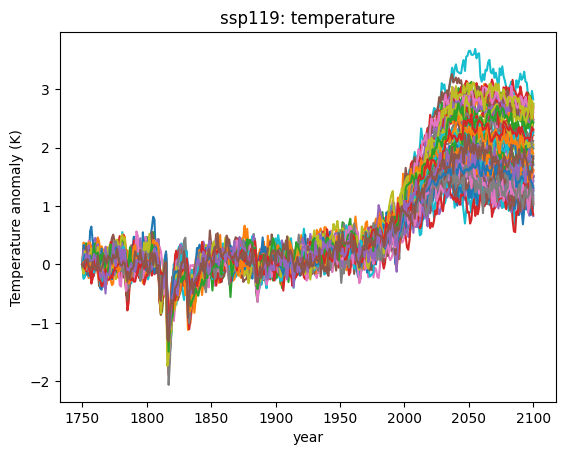

In [38]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp119', layer=0)], label=f.configs);
pl.title('ssp119: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

Text(0, 0.5, 'Temperature anomaly (K)')

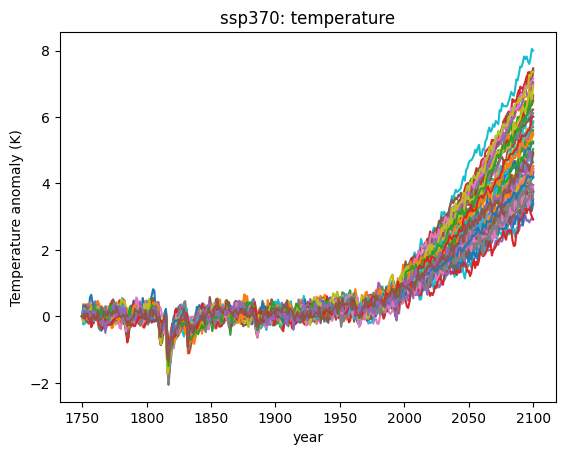

In [39]:
pl.plot(f.timebounds, f.temperature.loc[dict(scenario='ssp370', layer=0)], label=f.configs);
pl.title('ssp370: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')
#pl.legend()

Text(0, 0.5, 'W m$^{-2}$')

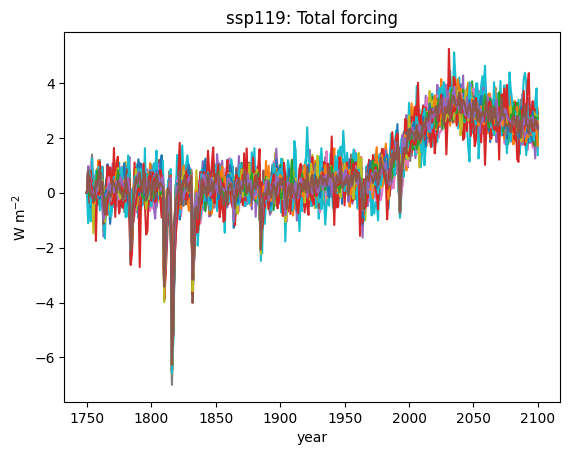

In [43]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp119')], label=f.configs);
pl.title('ssp119: Total forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')

Text(0, 0.5, 'W m$^{-2}$')

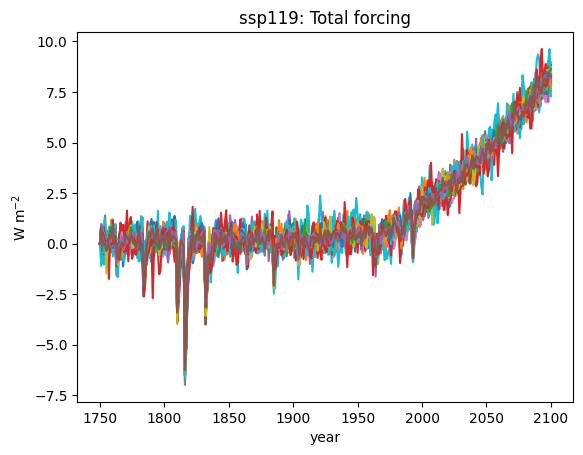

In [44]:
pl.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='ssp370')], label=f.configs);
pl.title('ssp119: Total forcing')
pl.xlabel('year')
pl.ylabel('W m$^{-2}$')